In [21]:
import os
import numpy as np
from PIL import Image
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Start Spark session
spark = SparkSession.builder.appName("AnimalImageClassifier_RF").getOrCreate()

# Function to load and flatten images
def load_images(folder_path, label, img_size=(32, 32)):
    data = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(folder_path, file)).convert("L").resize(img_size)
            img_array = np.array(img).flatten() / 255.0
            data.append((img_array.tolist(), label))
    return data

# Load training data (cats, dogs, horses)
base_path = "/Users/senakshikrishnamurthy/Desktop/Sena/Project/Classification"
train_data = []
train_data += load_images(os.path.join(base_path, "cats"), 0)
train_data += load_images(os.path.join(base_path, "dogs"), 1)
train_data += load_images(os.path.join(base_path, "horses"), 2)

# Convert to DataFrame
train_df = spark.createDataFrame(train_data, ["features", "label"])
to_vector_udf = udf(lambda x: Vectors.dense(x), returnType=VectorUDT())
train_df = train_df.withColumn("features_vec", to_vector_udf("features")).select("features_vec", col("label").cast("int"))

# Train Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features_vec", numTrees=50)
model = rf.fit(train_df)

# Load test images (cats, dogs, horses, rabbit)
test_data = []
test_data += load_images(os.path.join(base_path, "test/cats"), 0)
test_data += load_images(os.path.join(base_path, "test/dogs"), 1)
test_data += load_images(os.path.join(base_path, "test/horses"), 2)
test_data += load_images(os.path.join(base_path, "test/rabbits"), 3)  # unknown class

test_df = spark.createDataFrame(test_data, ["features", "label"])
test_df = test_df.withColumn("features_vec", to_vector_udf("features")).select("features_vec", col("label").cast("int"))

# Predict on test set
predictions = model.transform(test_df)
predictions.select("label", "prediction").show(truncate=False)

# Evaluate accuracy only on known classes
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
known_predictions = predictions.filter(col("label") < 3)

if known_predictions.count() > 0:
    accuracy = evaluator.evaluate(known_predictions)
    print(f"Validation Accuracy (Known Classes): {accuracy:.2f}")
else:
    print("No known-class samples found for evaluation.")


+-----+----------+
|label|prediction|
+-----+----------+
|0    |0.0       |
|0    |0.0       |
|1    |1.0       |
|1    |1.0       |
|2    |2.0       |
|2    |1.0       |
|3    |1.0       |
|3    |1.0       |
|3    |2.0       |
|3    |0.0       |
+-----+----------+

Validation Accuracy (Known Classes): 0.83


In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Filter only known classes for evaluation
known_predictions = predictions.filter(col("label") < 3)

# Accuracy
accuracy = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
).evaluate(known_predictions)

# Precision (weighted)
precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
).evaluate(known_predictions)

# Recall (weighted)
recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
).evaluate(known_predictions)

# F1-score (weighted)
f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
).evaluate(known_predictions)

# Print results
print(f"Evaluation on Known Classes (Cats, Dogs, Horses):")
print(f"Accuracy : {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall   : {recall:.2%}")
print(f"F1 Score : {f1:.2%}")


Evaluation on Known Classes (Cats, Dogs, Horses):
Accuracy : 83.33%
Precision: 88.89%
Recall   : 83.33%
F1 Score : 82.22%


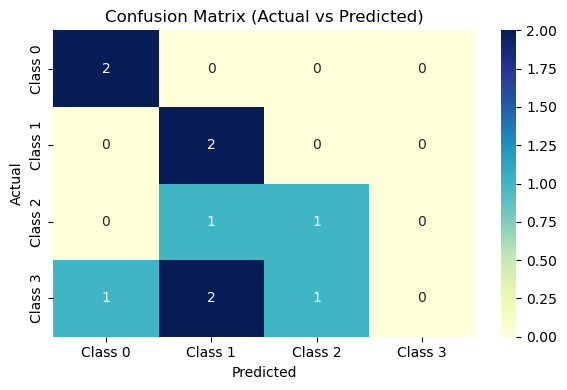

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Manually input confusion matrix from your Spark output
# True labels: [0, 0, 1, 1, 2, 2, 3, 3, 3, 3]
# Predictions: [0, 0, 1, 1, 2, 1, 1, 1, 2, 0]
conf_matrix = np.array([
    [2, 0, 0, 0],  # True 0
    [0, 2, 0, 0],  # True 1
    [0, 1, 1, 0],  # True 2
    [1, 2, 1, 0]   # True 3 misclassified as 0,1,2
])

labels = ["Class 0", "Class 1", "Class 2", "Class 3"]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Actual vs Predicted)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


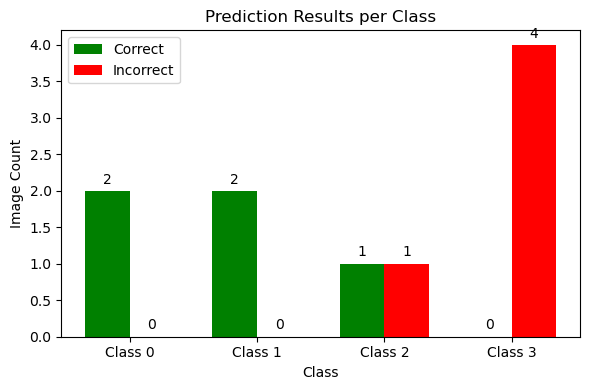

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Data
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
correct = [2, 2, 1, 0]
incorrect = [0, 0, 1, 4]
x = np.arange(len(classes))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bar1 = ax.bar(x - width/2, correct, width, label='Correct', color='green')
bar2 = ax.bar(x + width/2, incorrect, width, label='Incorrect', color='red')

# Add labels
for i in range(len(classes)):
    ax.text(x[i] - width/2, correct[i] + 0.1, f"{correct[i]}", ha='center')
    ax.text(x[i] + width/2, incorrect[i] + 0.1, f"{incorrect[i]}", ha='center')

# Style
ax.set_title("Prediction Results per Class")
ax.set_xlabel("Class")
ax.set_ylabel("Image Count")
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.tight_layout()
plt.show()


In [9]:
spark.stop()
